# Implied Volatility Calculation and Visualization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

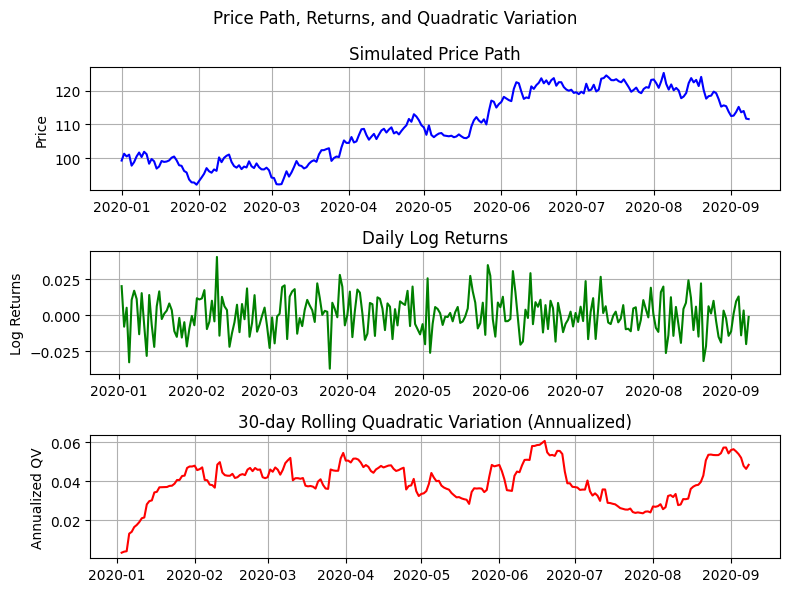

In [2]:
# Generate simulated price path
n_days = 252  # One trading year
dt = 1/252    # Daily time step
mu = 0.05     # Drift (5% annual return)
sigma = 0.2   # Volatility (20% annual)

# Generate random walk
dW = np.random.normal(0, np.sqrt(dt), n_days)
returns = mu*dt + sigma*dW
price_path = 100 * np.exp(np.cumsum(returns))

# Calculate daily returns
daily_returns = np.diff(np.log(price_path))

# Calculate rolling annualized quadratic variation (30-day window)
window = 30
qv = np.array([np.sum(daily_returns[max(0,i-window):i]**2)*252/window
               for i in range(1, len(daily_returns))])

# Create date range for x-axis
dates = [datetime(2020,1,1) + timedelta(days=x) for x in range(n_days)]

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6))
fig.suptitle('Price Path, Returns, and Quadratic Variation')

# Plot 1: Price path
ax1.plot(dates, price_path, 'b-')
ax1.set_ylabel('Price')
ax1.set_title('Simulated Price Path')
ax1.grid(True)

# Plot 2: Returns
ax2.plot(dates[1:], daily_returns, 'g-')
ax2.set_ylabel('Log Returns')
ax2.set_title('Daily Log Returns')
ax2.grid(True)

# Plot 3: Quadratic Variation
ax3.plot(dates[2:], qv, 'r-')  # Removed *np.sqrt(12) since QV is already annualized with *252
ax3.set_ylabel('Annualized QV')
ax3.set_title(f'{window}-day Rolling Quadratic Variation (Annualized)')
ax3.grid(True)

plt.tight_layout()
plt.show()

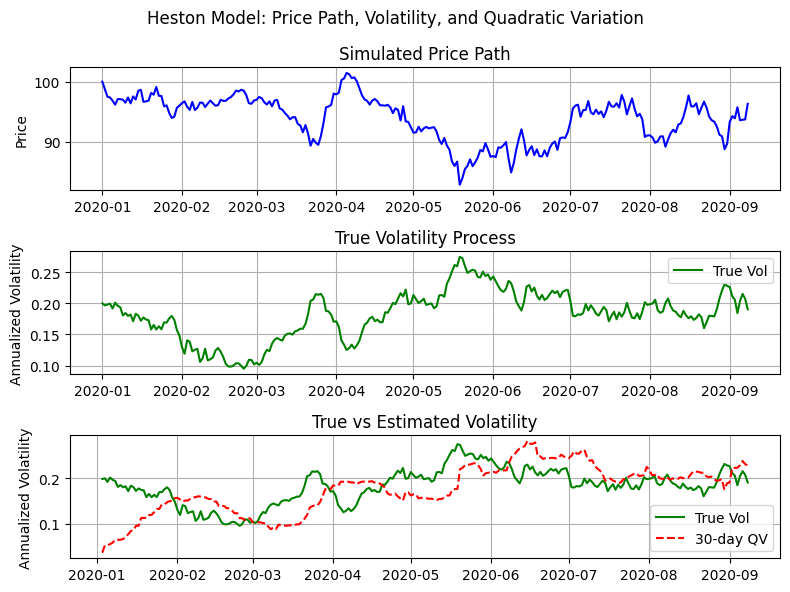


Correlation between 30-day realized QV and true volatility: 0.473


In [3]:
# Heston model parameters
kappa = 2.0    # Mean reversion speed
theta = 0.04   # Long-run variance
xi = 0.3       # Vol of vol
rho = -0.7     # Correlation between price and vol
v0 = 0.04      # Initial variance

# Simulate Heston model
v = np.zeros(n_days)
v[0] = v0
price_path_h = np.zeros(n_days)
price_path_h[0] = 100

# Generate correlated Brownian motions
dW1 = np.random.normal(0, np.sqrt(dt), n_days)
dW2 = rho * dW1 + np.sqrt(1 - rho**2) * np.random.normal(0, np.sqrt(dt), n_days)

# Simulate paths
for t in range(1, n_days):
    v[t] = v[t-1] + kappa*(theta - v[t-1])*dt + xi*np.sqrt(v[t-1])*dW2[t]
    v[t] = max(v[t], 0)  # Ensure variance stays positive
    price_path_h[t] = price_path_h[t-1] * np.exp((mu - 0.5*v[t])*dt + np.sqrt(v[t])*dW1[t])

# Calculate daily returns for Heston
daily_returns_h = np.diff(np.log(price_path_h))

# Calculate rolling QV for Heston
qv_h = np.array([np.sum(daily_returns_h[max(0,i-window):i]**2)*252/window
                 for i in range(1, len(daily_returns_h))])

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6))
fig.suptitle('Heston Model: Price Path, Volatility, and Quadratic Variation')

# Plot 1: Price path
ax1.plot(dates, price_path_h, 'b-')
ax1.set_ylabel('Price')
ax1.set_title('Simulated Price Path')
ax1.grid(True)

# Plot 2: True volatility process
ax2.plot(dates, np.sqrt(v), 'g-', label='True Vol')
ax2.set_ylabel('Annualized Volatility')
ax2.set_title('True Volatility Process')
ax2.grid(True)
ax2.legend()

# Plot 3: Quadratic Variation vs True Volatility
ax3.plot(dates[2:], np.sqrt(v[2:]), 'g-', label='True Vol')
ax3.plot(dates[2:], np.sqrt(qv_h), 'r--', label='30-day QV')
ax3.set_ylabel('Annualized Volatility')
ax3.set_title('True vs Estimated Volatility')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

# Calculate correlation between QV and true volatility
qv_vol_corr = np.corrcoef(np.sqrt(qv_h), np.sqrt(v[2:]))[0,1]
print(f"\nCorrelation between 30-day realized QV and true volatility: {qv_vol_corr:.3f}")